In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm
from misc import *
import os 

import tensorflow as tf
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We consider an harmonic oscillator under continuous measurement, with $[q,p] = i \hbar$. Defining normalized quadratures according to $q \rightarrow \sqrt{\frac{m \omega}{\hbar}} q$, $p \rightarrow \frac{p}{\sqrt{m \omega \hbar}}$,(¿under Ehrenfest theorem?), for the first moment of each quadrature we get

$\begin{equation}
\left( \begin{array}{c} \langle \dot{q} \rangle \\ \langle \dot{p} \rangle \\ \end{array}\right)
= 
\left( \begin{array}{cc}
0 & \omega \\
-\omega & 0
\end{array} \right)
\left( \begin{array}{c} \langle q \rangle \\ \langle p \rangle \\ \end{array}\right)
\end{equation}
$

or just $\dot{\textbf{q}} = A \textbf{q}$. We now imagine the field is inside a cavity, and continuously monitored via homodyne detection (check matrix C below, does it correspond to homodyne? only first entry...). Under Langevin equation we get a stochastic evolution for the first two moments:

\begin{eqnarray}
 d\textbf{q} &=& \big(A - C \chi(\Sigma) \big)\textbf{q} dt + \chi(\Sigma) dy \\
\dot{\Sigma} &=& A \Sigma + \Sigma A^\dagger + \Gamma - \chi(\Sigma) \chi^\dagger(\Sigma) \\
d\textbf{y} &=&  C \textbf{q} dt + dW \\
\end{eqnarray}

where $\textbf{y}$ is the measurement current and $\chi(\Sigma) = \Sigma C^\dagger + \Gamma^\dagger$

In [12]:

path = "/home/cooper-cooper/continous/"
periods = 5
ppp = 400
itraj = 0

#define parameters
gamma = 1 #damping from outside
Gamma = 1 #measurement rate
eta = 1 # measurement efficiency
n = 2 # number of photons?
w = 1
T = 2*np.pi/w

C = np.array([[np.sqrt(4*eta*Gamma), 0] ,[0, np.sqrt(4*eta*Gamma)]])

A = np.array([
    [0., w],
    [-w, 0.]])

D = np.array([[gamma*(n + 0.5) + Gamma, 0], [0,gamma*(n + 0.5) + Gamma]])

su = n + 0.5 + Gamma/gamma
cov_in = np.array([[np.sqrt(1+ (16*eta*Gamma*su/gamma) -1)*gamma/(8*eta*Gamma), 0],
                   [0,np.sqrt(1+ (16*eta*Gamma*su/gamma) -1)*gamma/(8*eta*Gamma)]])

dt = T/ppp
total_points = int(T*periods/dt)

xi = lambda cov: np.dot(cov, ct(C)) #+ ct(Gamma_matrix)

signals = []
covs = [cov_in]
means = [np.array([1.,0.])] ## initial condition
xicovs = [xi(covs[-1])]

for k in tqdm(range(total_points)):
    x = means[-1]
    cov = covs[-1]
    XiCov = xicovs[-1]

    ##deterministic (just to check)
    #dy = np.dot(C, x )*dt
    dy = np.dot(C, x + np.dot(np.linalg.pinv(C), np.random.randn(2)/np.sqrt(dt)))*dt # signal
    signals.append(dy)

    dx = np.dot(A - np.dot(XiCov,C), x)*dt + np.dot(XiCov, dy)  #evolution update (according to what you measure)
    dcov = (np.dot(A,cov) + np.dot(cov, ct(A)) + D - np.dot(XiCov, ct(XiCov)))*dt  #covariance update

    covs.append(covs[-1] + dcov)
    means.append(means[-1] + dx)
    xicovs.append(xi(covs[-1]))

os.makedirs(path+"{}/".format(itraj), exist_ok=True)
np.save(path+"{}/means".format(itraj),np.array(means) )
np.save(path+"{}/covs".format(itraj),np.array(covs) )
np.save(path+"{}/signals".format(itraj),np.array(signals) )
np.save(path+"{}/xicovs".format(itraj),np.array(xicovs) )
np.save(path+"{}/D".format(itraj),D)
np.save(path+"{}/C".format(itraj),C)
np.save(path+"{}/dt".format(itraj),np.array([dt]))
np.save(path+"{}/A".format(itraj),A)


100%|██████████| 1999/1999 [00:00<00:00, 11568.27it/s]


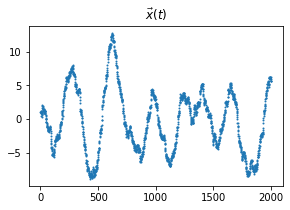

In [13]:
plt.figure(figsize=(10,10))
plt.subplot(321)
plt.title(r'$\vec{x}(t)$')
for ind, c in enumerate(["red"]):
    plt.scatter(range(len(means)),np.array(means)[:,ind], s=1)

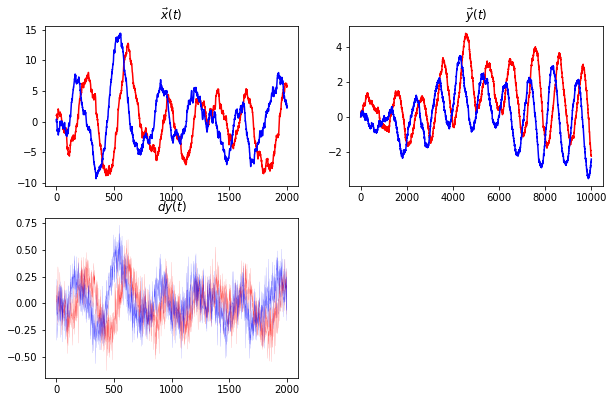

In [14]:
plt.figure(figsize=(10,10))
plt.subplot(321)
plt.title(r'$\vec{x}(t)$')
for ind, c in enumerate(["red","blue"]):
    plt.plot(np.array(means)[:,ind], color=c)
plt.subplot(322)
plt.title(r'$\vec{y}(t)$')
for ind, c in enumerate(["red","blue"]):
    plt.plot(np.array(j)[:,ind], color=c)
    
plt.subplot(323)
plt.title(r'$d\vec{y}(t)$')
for ind, c in enumerate(["red","blue"]):
    plt.plot(np.array(signals)[:,ind], color=c, linewidth=0.1)